# Setup

In [1]:
# Install packages
!pip install xmltodict

# Import required packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import glob
import imageio
import cv2
import argparse
import imutils
import json
import xmltodict
import pprint
import json
import ast
import pandas as pd
from PIL import Image 
import seaborn as sns
import PIL 
from typing import Tuple
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab.patches import cv2_imshow   # needed for colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [9]:
IMAGE_PATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/01_PHASE1_VOC/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/'
LABEL_PATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/01_PHASE1_VOC/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/Annotations/'
SYNTHETIC_IMAGE_PATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/00_PHASE0_SYNTHETIC_DATASET'

# Extract Labels from Annotations

In [7]:
# list out the image files
image_files = os.listdir(IMAGE_PATH)
print(len(image_files))
image_files[:5]

17125


['2012_003185.jpg',
 '2012_001577.jpg',
 '2012_002639.jpg',
 '2012_002992.jpg',
 '2012_003686.jpg']

In [9]:
# list out the annotation files
annotation_files = os.listdir(LABEL_PATH)
print(len(annotation_files))
annotation_files[:5]

17125


['2009_004247.xml',
 '2009_004248.xml',
 '2009_004249.xml',
 '2009_004255.xml',
 '2009_004258.xml']

In [4]:
# list out the SYNTHETIC files
synthetic_files = os.listdir(SYNTHETIC_IMAGE_PATH)
print(len(synthetic_files))
synthetic_files[:5]

8000


['rgb_6989.png',
 'rgb_6994.png',
 'rgb_6976.png',
 'rgb_6984.png',
 'rgb_7015.png']

# Feature Vector Functions

In [21]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int] = (128,128), 
                    padding_color: Tuple[int] = (255, 255, 255)) -> np.array:
    """
    https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
    Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image


def get_hog_feature_vector(image, blur_value=5, orientations=9, pixels_per_cell=16, cells_per_block=2):
    
    # blur image first to remove some noise
    image_blurred = cv2.GaussianBlur(image, (blur_value, blur_value), 0) 

    hog_feature_vector, hog_image = hog(image_blurred, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                        cells_per_block=(cells_per_block, cells_per_block), visualize=True, channel_axis=-1)

    return hog_feature_vector


def display_hog_feature_vector(image, blur_value=5, orientations=9, pixels_per_cell=16, cells_per_block=2):
    
    # blur image first to remove some noise
    image_blurred = cv2.GaussianBlur(image, (blur_value, blur_value), 0) 

    hog_feature_vector, hog_image = hog(image_blurred, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                        cells_per_block=(cells_per_block, cells_per_block), visualize=True, channel_axis=-1)

    fig, ax = plt.subplots()

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax.axis('off')
    ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax.set_title('Histogram of Oriented Gradients')
    plt.plot(hog_image_rescaled)
    plt.show()


def get_hsv_feature_vector(image, bins=32):
    
    # cv2.calcHist([images], [channels], [mask], [bins], [hist_range])

    # do not use a padded or resized image
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # get the color histograms
    hue = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])
    sat = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])
    val = cv2.calcHist([hsv_image], [0], None, [bins], [0, 256])
    
    # combine the information into one vector
    hsv_feature_vector = np.concatenate([hue, sat, val], axis=0)
    hsv_feature_vector = hsv_feature_vector.reshape(-1)

    return hsv_feature_vector


def display_hsv_histogram(image):
    
    H, S, V = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2HSV))
    image = cv2.cvtColor(cv2.merge([H, S, V]), cv2.COLOR_HSV2RGB)

    h, s, v = image[:, : ,0], image[:, :, 1], image[:, :, 2]
    hist_h = cv2.calcHist([h],[0],None,[256],[0,256])
    hist_s = cv2.calcHist([s],[0],None,[256],[0,256])
    hist_v = cv2.calcHist([v],[0],None,[256],[0,256])
    plt.plot(hist_h, color='r', label='h')
    plt.plot(hist_s, color='g', label='s')
    plt.plot(hist_v, color='b', label='v')
    plt.legend()
    plt.figure(figsize=(12,6))
    plt.show()


def get_sift_feature_vector(image, max_keypoints=20):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur image to remove noise
    image_blurred = cv2.GaussianBlur(gray_image, (3,3), 0) 

    # keypoints
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=max_keypoints)
    keypoints, descriptors = sift.detectAndCompute(image_blurred, None)

    return keypoints, descriptors


def display_sift_features(image, max_keypoints=50):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur image to remove noise
    image_blurred = cv2.GaussianBlur(gray_image, (5,5), 0) 

    #keypoints
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=max_keypoints)
    keypoints, descriptors = sift.detectAndCompute(image_blurred, None)

    img_sift = cv2.drawKeypoints(gray_image, keypoints, image)
    plt.imshow(img_sift)


def flatten_sift_descriptors(sift_descriptor):

    flattened_sift_descriptor = sift_descriptor.flatten()
    
    return flattened_sift_descriptor

# Preprocessing Functions

In [11]:
def get_unpadded_image_data(image_file_path):
    
    image_unpadded = plt.imread(image_file_path)

    return image_unpadded


def get_padded_image_data(image_unpadded, pad_size=128):
    
    image_padded = resize_with_pad(image_unpadded, (pad_size, pad_size))
    
    return image_padded

In [12]:
def get_name_and_label_from_xml(file_path, filename):

    '''
    Retrieve the image name and label from .xml annotation
    Returns two objects
    1. image name
    2. image label
    '''

    with open(file_path + '/' + filename) as xml_file:

        # convert xml file to dictionary, then read it as a json object
        data_dict = xmltodict.parse(xml_file.read())
        json_data = json.loads(json.dumps(data_dict))
        
        # image filename
        name = json_data['annotation']['filename'].split('.')[0]

        # some labels are nested more than others
        try:
            label = json_data['annotation']['object']['name']
        except TypeError:
            label = json_data['annotation']['object'][0]['name']

    return name, label

In [13]:
def get_image_data_from_xml(path, filename):
    '''
    the annoations contain important information regarding the
    classified label objects in each image along with their bounding boxes

    each image can have more than one object

    this function returns a single nested dictionary where 
    a. the top level key is the image file
    b. nested keys are each object and their bounding box
    '''

    with open(path + filename) as xml_file:

        # convert xml file to dictionary, then read it as a json object
        data_dict = xmltodict.parse(xml_file.read())
        json_data = json.loads(json.dumps(data_dict))
        
        # image filename
        image_filename = json_data['annotation']['filename']

        # dictionary to hold information for all objects
        objects_in_image_dict = {}

        # dictionary for each object label and its bounding box
        object_info_dict = {}

        # get object information
        image_objects = json_data['annotation']['object']

        # if there is only one object, the info will just be in a dictionary (no list)
        
        if type(image_objects) == dict:
            obj_label = image_objects['name']
            obj_bounding_box = image_objects['bndbox']
            object_info_dict[obj_label] = obj_bounding_box
        
        # otherwise there is more than one object, the info will be in a list of dictionaries
        else:
            for obj in image_objects:
                obj_label = obj['name']
                obj_bounding_box = obj['bndbox']
                object_info_dict[obj_label] = obj_bounding_box

        objects_in_image_dict[image_filename] = object_info_dict

        return objects_in_image_dict

In [14]:
def crop_objects_from_image(input_filepath, filename, object_dict, output_filepath):
    '''
    this function uses the bounding boxes provided in the object_dict
    to crop objects from the input file and saves the unpadded version to the output_filepath

    this function does not return any information
    '''

    image = plt.imread(input_filepath + filename)

    # retrieve bounding boxes
    image_objects = list(object_dict[filename].keys())

    for obj in image_objects:

        # crop based on bounding box
        X = int(float(object_dict[filename][obj]['xmin']))
        Y = int(float(object_dict[filename][obj]['ymin']))
        W = int(float(object_dict[filename][obj]['xmax']))
        H = int(float(object_dict[filename][obj]['ymax']))

        cropped_image = image[Y:Y+H, X:X+W]
        
        # save cropped object
        im = Image.fromarray(cropped_image)
        im.save(output_filepath + filename.split('.')[0] + '_' + obj + '.jpg')

    return

# Function Testing

## motorbike 128

(128, 128, 3)


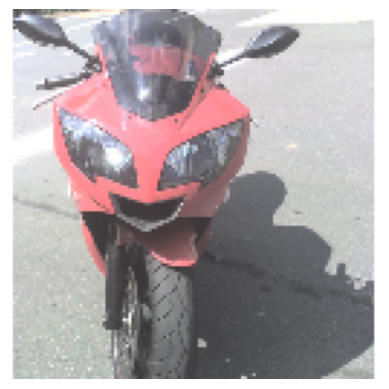

In [ ]:
image_padded_128 = resize_with_pad(cropped_image, (128, 128))
plt.axis('off')
plt.imshow(image_padded_128)
print(image_padded_128.shape)

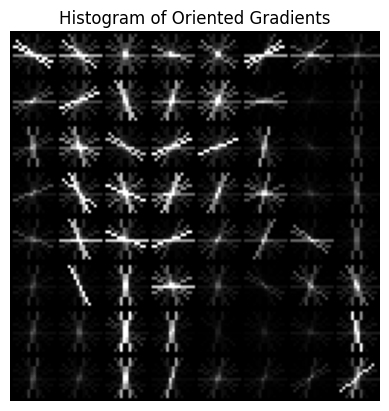

In [ ]:
display_hog_feature_vector(image_padded_128)

In [ ]:
get_hog_feature_vector(image_padded_128, 5, 9, 4, 2)

array([0.20003623, 0.        , 0.12490373, ..., 0.        , 0.34589391,
       0.36224928])

In [ ]:
# HOG feature vector with resized size image

hog_feature_vector = get_hog_feature_vector(image_padded_128)
print(f'HOG feature vector of length {len(hog_feature_vector)}: ', hog_feature_vector)

HOG feature vector of length 1764:  [0.08310665 0.02177855 0.0672388  ... 0.03711239 0.05516818 0.33090429]


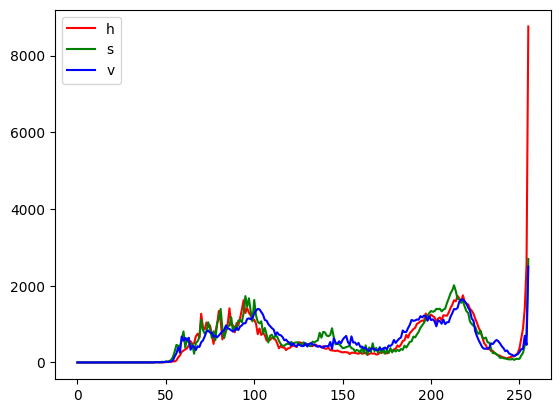

<Figure size 1200x600 with 0 Axes>

In [ ]:
display_hsv_histogram(cropped_image)

In [ ]:
'''
Indices
Hue: 0-31
Saturation: 32-63
Value: 64-95
'''

get_hsv_feature_vector(image_unpadded)

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
       1.8000e+01, 6.7000e+01, 1.8510e+03, 4.3830e+03, 5.9540e+03,
       6.7830e+03, 7.7620e+03, 1.0184e+04, 8.8460e+03, 6.0180e+03,
       4.0180e+03, 4.2020e+03, 3.4020e+03, 2.7970e+03, 2.5630e+03,
       2.3520e+03, 2.3260e+03, 3.1290e+03, 6.5750e+03, 1.2857e+04,
       1.6982e+04, 1.7651e+04, 2.0123e+04, 1.0785e+04, 6.6830e+03,
       6.7350e+03, 2.4949e+04, 7.3280e+04, 6.3151e+04, 2.5752e+04,
       9.5490e+03, 5.4620e+03, 2.9910e+03, 2.3330e+03, 2.0740e+03,
       1.7840e+03, 1.6850e+03, 2.0330e+03, 1.5920e+03, 1.7090e+03,
       2.7510e+03, 2.9440e+03, 7.3600e+02, 1.3500e+02, 3.1000e+01,
       4.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3741e+04,
       2.2190e+03, 3.4270e+03, 7.9970e+03, 6.6380e+03, 6.1270e+03,
       7.3630e+03, 2.5640e+03, 4.1500e+03, 5.3700e+03, 4.8410e

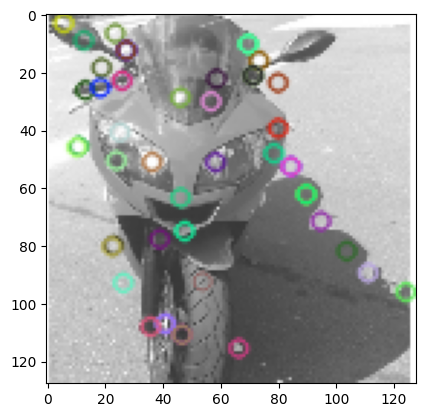

In [ ]:
display_sift_features(image_padded_128)

In [ ]:
'''
Each ***keypoint*** has a location, scale, orientation. 
Each ***descriptor*** stores the local image region about each keypoint 
  that is distinct and invariant to variations such as changes in viewpoint and illumination
'''

keypoints, descriptors = get_sift_feature_vector(image_padded_128)
print('keypoints: ', keypoints[:3])
print('descriptors: ', descriptors[:3])
print('number of features: ', len(flatten_sift_descriptors(descriptors)))

keypoints:  (< cv2.KeyPoint 0x7f74bf31f780>, < cv2.KeyPoint 0x7f745dc401e0>, < cv2.KeyPoint 0x7f745dd6e480>)
descriptors:  [[ 26.  73.  10.   6.   3.   1.   4.  10.  32. 131.  81.  48.   9.  10.
   26.  18.   0.   2.  29. 133.  47.  27.  35.   7.   0.   1.  23.  29.
    4.   8.  46.  20.  22.  17.  10.  21.  51.   9.   4.   4. 133.  41.
   25.   9.   1.   7.  47.  91.  15.   1.   6.  17.   8.  69. 133.  44.
    0.   0.   2.  17.  17.  30. 133.  42.  25.   1.   0.   3.  63.  23.
   35.  16. 133.  24.   0.   0.   1.  10.  17.  35.  86.   8.   0.   9.
   52.  60.  40.  15.   0.   0.  14.  95.  86.  43.  21.   2.  14.   0.
    0.   2.  27.  36.  30.  53. 133.   6.   0.   0.   3.  32.  15.  29.
  102.   4.   0.   2.  46.  26.   0.   7.   0.   0.   0.   8. 133.  50.
    0.   0.]
 [  0.   0.   2. 108.  85.   0.   0.   0.   3.   3.  27.  85.  32.   5.
    2.   3.   0.   0.   5.  46.  21.  17.   4.   1.   0.   0.   0.   0.
    0.   0.   0.   0.  14.   6.  10. 143. 143.   0.   0.   1. 137.  23.


## motorbike 640

(640, 640, 3)


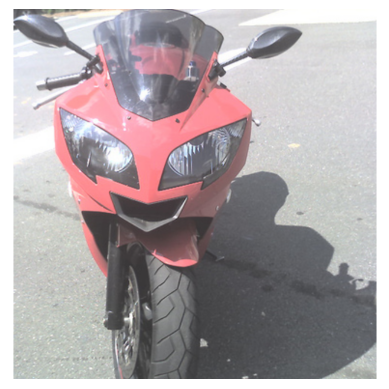

In [ ]:
image_padded_640 = resize_with_pad(cropped_image, (640, 640))
plt.axis('off')
plt.imshow(image_padded_640)
print(image_padded_640.shape)

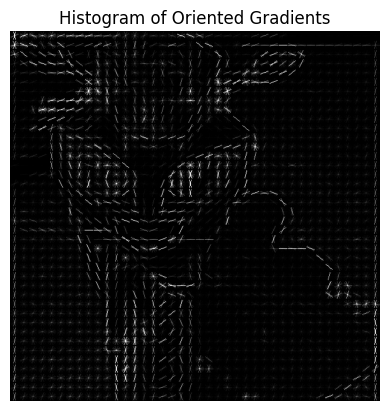

In [ ]:
display_hog_feature_vector(image_padded_640)

In [ ]:
get_hog_feature_vector(image_padded_640, 5, 9, 4, 2)

array([0.08114314, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
# HOG feature vector with resized size image

hog_feature_vector = get_hog_feature_vector(image_padded_640)
print(f'HOG feature vector of length {len(hog_feature_vector)}: ', hog_feature_vector)

HOG feature vector of length 54756:  [0.29782527 0.01251049 0.08641456 ... 0.1136894  0.16101856 0.35438881]


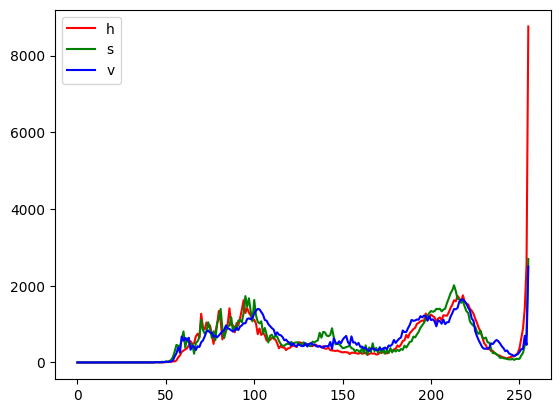

<Figure size 1200x600 with 0 Axes>

In [ ]:
display_hsv_histogram(cropped_image)

In [ ]:
'''
Indices
Hue: 0-31
Saturation: 32-63
Value: 64-95
'''

get_hsv_feature_vector(image_unpadded)

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
       1.8000e+01, 6.7000e+01, 1.8510e+03, 4.3830e+03, 5.9540e+03,
       6.7830e+03, 7.7620e+03, 1.0184e+04, 8.8460e+03, 6.0180e+03,
       4.0180e+03, 4.2020e+03, 3.4020e+03, 2.7970e+03, 2.5630e+03,
       2.3520e+03, 2.3260e+03, 3.1290e+03, 6.5750e+03, 1.2857e+04,
       1.6982e+04, 1.7651e+04, 2.0123e+04, 1.0785e+04, 6.6830e+03,
       6.7350e+03, 2.4949e+04, 7.3280e+04, 6.3151e+04, 2.5752e+04,
       9.5490e+03, 5.4620e+03, 2.9910e+03, 2.3330e+03, 2.0740e+03,
       1.7840e+03, 1.6850e+03, 2.0330e+03, 1.5920e+03, 1.7090e+03,
       2.7510e+03, 2.9440e+03, 7.3600e+02, 1.3500e+02, 3.1000e+01,
       4.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3741e+04,
       2.2190e+03, 3.4270e+03, 7.9970e+03, 6.6380e+03, 6.1270e+03,
       7.3630e+03, 2.5640e+03, 4.1500e+03, 5.3700e+03, 4.8410e

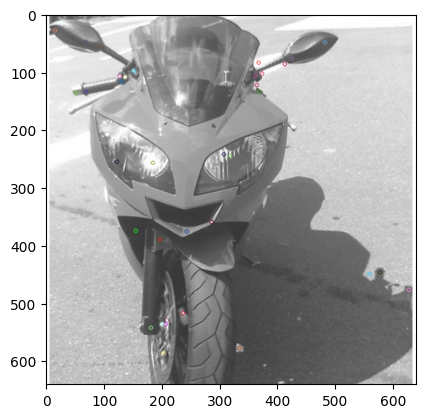

In [ ]:
display_sift_features(image_padded_640)

In [ ]:
'''
Each ***keypoint*** has a location, scale, orientation. 
Each ***descriptor*** stores the local image region about each keypoint 
  that is distinct and invariant to variations such as changes in viewpoint and illumination
'''

keypoints, descriptors = get_sift_feature_vector(image_padded_640)
print('keypoints: ', keypoints[:3])
print('descriptors: ', descriptors[:3])
print('number of features: ', len(flatten_sift_descriptors(descriptors)))

keypoints:  (< cv2.KeyPoint 0x7f74bf308ea0>, < cv2.KeyPoint 0x7f74bf3083c0>, < cv2.KeyPoint 0x7f745dbf5ba0>)
descriptors:  [[  1.   1.   1.  10.  65. 120.  75.  11.   0.   0.   0.   2.  50.  55.
   27.  20.   1.   0.   0.   0.   2.  11.  76.  26.   2.   0.   0.   0.
    1.   3.  35. 120.  11.  14.  57. 120.  78.  20.   4.   4.  70.   8.
    5.  32.  47.  15.  67. 120.   9.   3.   3.   1.   1.  27. 120.  81.
    4.   0.   0.   0.   0.   2.  96. 120.  30.  16.  29.  62.  16.   8.
   13.  19. 120.  72.  11.   7.   1.   1.  14.  63.  57.  54.  27.   3.
    2.  10.  26.  57.  24.   1.   0.   0.   0.   1.  25.  73.  33.   6.
    0.   0.   1.   3.  52. 116.  19.   7.   0.   0.   0.   0. 120. 117.
   26.   7.   1.   0.   0.   0.  24. 120.   9.   0.   0.   0.   0.   0.
    2.  43.]
 [  6.  38.  19.   0.   0.   0.   6.  17.  22.  24.   4.   0.   0.   0.
   16.  40.   9.   1.   0.   0.   0.  15.  94.  57.   0.   0.   0.   0.
    0.  45. 123.   2.  36.  78.  36.   2.   0.   0.   0.   4. 123.  50.


# Test Feature Vectors

## Test Image

(640, 640, 3)


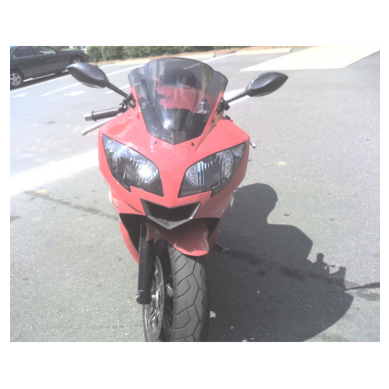

In [15]:
# load test image

image_file_path = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/01_PHASE1_VOC/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2009_004249.jpg'

try:
    image_unpadded = plt.imread(image_file_path)
    image_padded = resize_with_pad(image_unpadded, (640, 640))
    plt.axis('off')
    plt.imshow(image_padded)
    print(image_padded.shape)
except FileNotFoundError:
    print('image not found')

## HOG Feature Vector

In [ ]:
# use this set of parameters (pixels per cell = 4) for accuracy optimization
get_hog_feature_vector(image_padded, 5, 9, 4, 2)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# use this set of parameters (pixels per cell = 24) for efficiency optimization
get_hog_feature_vector(image_padded, 5, 9, 24, 2)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# HOG feature vector with resized size image

hog_feature_vector = get_hog_feature_vector(image_padded)
print(f'HOG feature vector of length {len(hog_feature_vector)}: ', hog_feature_vector)

HOG feature vector of length 54756:  [0. 0. 0. ... 0. 0. 0.]


### Baseline

(128, 128, 3)


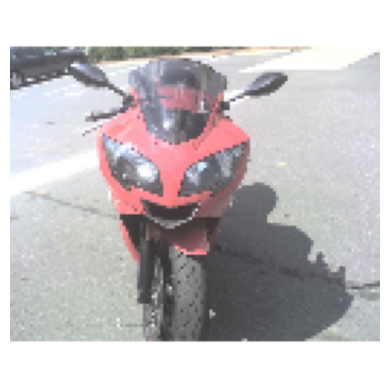

In [17]:
image_padded_128 = resize_with_pad(image_unpadded, (128, 128))
plt.axis('off')
plt.imshow(image_padded_128)
print(image_padded_128.shape)

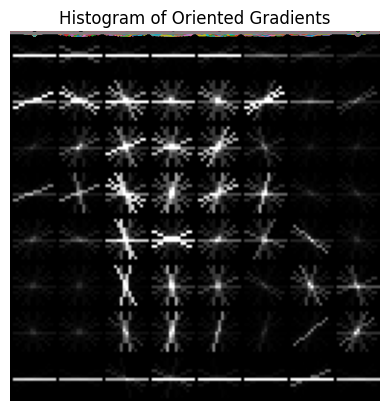

In [22]:
display_hog_feature_vector(image_padded_128, pixels_per_cell=16)

### Efficiency

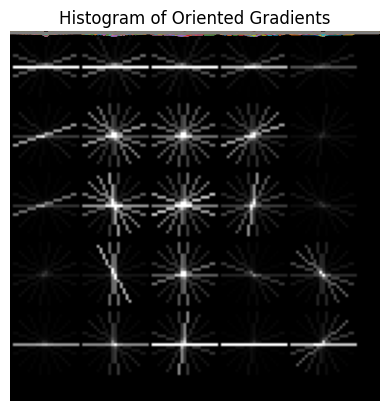

In [23]:
display_hog_feature_vector(image_padded_128, pixels_per_cell=24)

### Accuracy

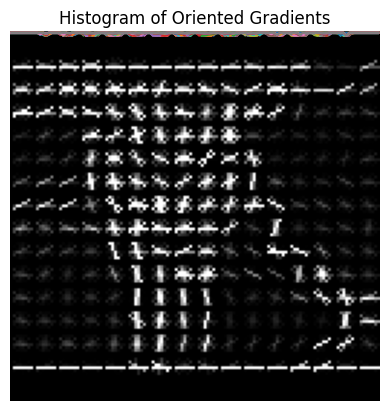

In [24]:
display_hog_feature_vector(image_padded_128, pixels_per_cell=8)

## HSV Feature Vector

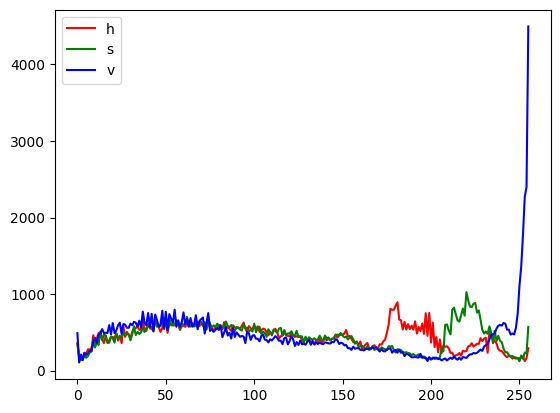

<Figure size 1200x600 with 0 Axes>

In [ ]:
display_hsv_histogram(image_unpadded)

In [ ]:
'''
Indices
Hue: 0-31
Saturation: 32-63
Value: 64-95
'''

get_hsv_feature_vector(image_unpadded)

array([1.0940e+03, 2.6960e+03, 3.3150e+03, 3.4760e+03, 3.8420e+03,
       3.9270e+03, 4.3090e+03, 4.6560e+03, 4.8820e+03, 4.6210e+03,
       4.5230e+03, 4.2760e+03, 4.0120e+03, 3.7280e+03, 3.4760e+03,
       3.2580e+03, 2.9690e+03, 2.9120e+03, 3.2090e+03, 3.2130e+03,
       2.8720e+03, 2.7560e+03, 2.6570e+03, 2.1230e+03, 1.8060e+03,
       1.6480e+03, 1.5430e+03, 1.6320e+03, 2.2340e+03, 3.9700e+03,
       4.3820e+03, 1.4983e+04, 1.1516e+04, 1.6436e+04, 1.0918e+04,
       9.7330e+03, 8.6110e+03, 8.3030e+03, 8.9490e+03, 8.5510e+03,
       7.5140e+03, 6.4730e+03, 3.2060e+03, 2.6660e+03, 2.4580e+03,
       2.0550e+03, 1.8510e+03, 1.4070e+03, 1.1540e+03, 6.5900e+02,
       4.4000e+02, 3.6000e+02, 2.0800e+02, 2.2700e+02, 1.5400e+02,
       1.5200e+02, 6.5000e+01, 7.9000e+01, 6.8000e+01, 6.4000e+01,
       3.4000e+01, 2.2000e+01, 1.1000e+01, 6.5600e+02, 6.5220e+03,
       9.7160e+03, 1.2390e+04, 1.0593e+04, 7.6230e+03, 3.0960e+03,
       2.2140e+03, 6.1600e+02, 1.1470e+03, 2.0170e+03, 1.9260e

## SIFT Feature Vector

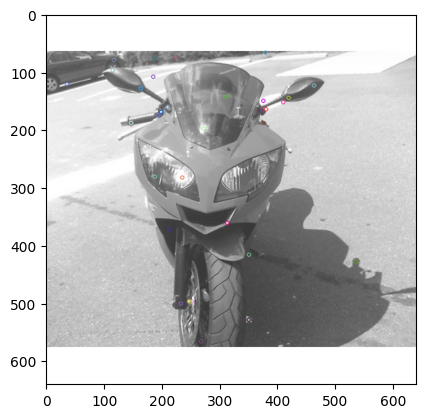

In [ ]:
display_sift_features(image_padded)

In [ ]:
'''
Each ***keypoint*** has a location, scale, orientation. 
Each ***descriptor*** stores the local image region about each keypoint 
  that is distinct and invariant to variations such as changes in viewpoint and illumination
'''

keypoints, descriptors = get_sift_feature_vector(image_padded)
print('keypoints: ', keypoints[:3])
print('descriptors: ', descriptors[:3])
print('number of features: ', len(flatten_sift_descriptors(descriptors)))

keypoints:  (< cv2.KeyPoint 0x7fde55604510>, < cv2.KeyPoint 0x7fde504e5f60>, < cv2.KeyPoint 0x7fde504e5f00>)
descriptors:  [[  1.   0.   0.  22.  98.   5.   8.  14. 122.   2.   0.   1.   4.   1.
   10.  84. 170.   6.   0.   0.   0.   0.   0. 100.  49.   2.   1.   8.
   33.   2.   2.  24.  10.   0.   0.   9.  67.  10.   8.  21. 118.  33.
    1.   1.   1.   4.  12.  42. 170.  91.   0.   0.   0.   0.   0.  30.
   59.  13.   2.  17.  63.   9.   0.   7.  28.   3.   1.  10.  38.   8.
    2.  13. 115.  10.   8.   3.   0.  10.  15.  44. 170.  21.   2.   0.
    0.   1.   1.  94.  51.  13.  17.  14.  18.  18.   1.   7.   8.   5.
    4.   9.  26.   6.   1.   3. 138.  11.  16.   8.   1.   1.   1.  44.
  170.  30.   6.   1.   0.   0.   0.  41.  10.  15.  29.  47.   6.   0.
    0.   0.]
 [ 42.   9.   1.  24.  30.   0.   0.   2. 138.   4.   1.  21.  11.   0.
    0.  38. 113.   1.   1.  12.  64.   3.   1.  33.   0.   0.   0.  30.
  138.   4.   0.   0.  53.   5.   2.  29.  39.   0.   0.   3. 138.  13.


# SYNTHETIC Feature Vectors

## Test Image - SYNTHETIC

(128, 128, 3)


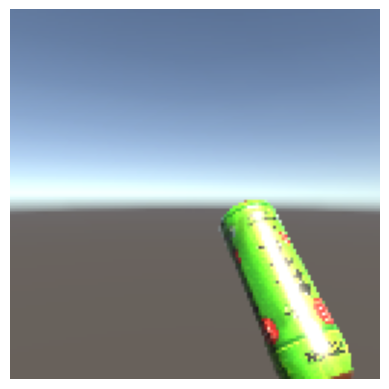

In [51]:
# load test image

image_file_path = SYNTHETIC_IMAGE_PATH + '/' + 'rgb_8000.png'

try:
    I = np.asarray(PIL.Image.open(image_file_path).convert('RGB'))
    image_padded = resize_with_pad(I, (128, 128))
    plt.axis('off')
    plt.imshow(image_padded)
    print(image_padded.shape)
except FileNotFoundError:
    print('image not found')

## HOG Feature Vector

In [52]:
# use this set of parameters (pixels per cell = 4) for accuracy optimization
get_hog_feature_vector(image_padded, 5, 9, 4, 2)

array([0.1429926, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ])

In [53]:
# use this set of parameters (pixels per cell = 24) for efficiency optimization
get_hog_feature_vector(image_padded, 5, 9, 24, 2)

array([9.15045414e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.24841117e-01, 3.60849327e-01, 4.28660780e-02, 0.00000000e+00,
       0.00000000e+00, 6.86284076e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.60849327e-01, 3.31254198e-01, 3.88221036e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.60849327e-01, 3.60849327e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.60849327e-01,
       3.60849327e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.21833643e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.76811843e-01, 3.48413190e-01, 4.08330915e-02, 0.00000000e+00,
       0.00000000e+00, 6.01528047e-03, 0.00000000e+00, 0.00000000e+00,
       3.24725594e-03, 3.76811843e-01, 1.52930682e-01, 3.91317115e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [54]:
# HOG feature vector with resized size image

hog_feature_vector = get_hog_feature_vector(image_padded)
print(f'HOG feature vector of length {len(hog_feature_vector)}: ', hog_feature_vector)

HOG feature vector of length 1764:  [0.01881004 0.         0.         ... 0.02505615 0.24769063 0.31194013]


## HSV Feature Vector

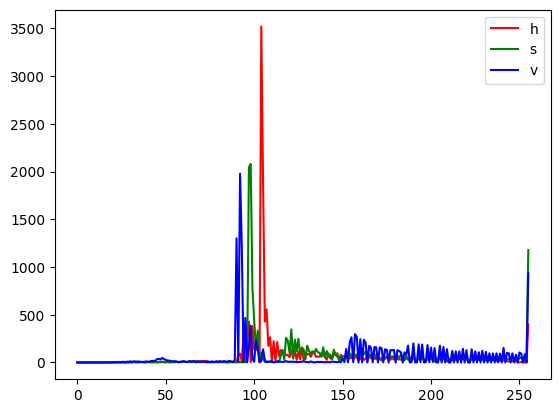

<Figure size 1200x600 with 0 Axes>

In [55]:
display_hsv_histogram(image_padded)

In [56]:
'''
Indices
Hue: 0-31
Saturation: 32-63
Value: 64-95
'''

get_hsv_feature_vector(image_padded)

array([0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 1.200e+01,
       2.500e+01, 4.100e+01, 2.500e+01, 1.700e+01, 1.200e+01, 1.300e+01,
       1.700e+01, 5.986e+03, 3.900e+01, 3.300e+01, 3.200e+01, 2.400e+01,
       8.200e+01, 1.186e+03, 1.024e+03, 9.370e+02, 7.570e+02, 6.000e+02,
       5.860e+02, 6.780e+02, 3.970e+02, 5.340e+02, 4.760e+02, 4.060e+02,
       4.710e+02, 1.969e+03, 2.970e+02, 6.740e+02, 1.147e+03, 3.875e+03,
       1.508e+03, 2.110e+02, 3.070e+02, 4.120e+02, 5.360e+02, 7.310e+02,
       1.383e+03, 2.166e+03, 2.145e+03, 3.300e+01, 4.000e+01, 3.700e+01,
       3.700e+01, 4.700e+01, 5.400e+01, 6.400e+01, 8.600e+01, 8.600e+01,
       7.300e+01, 1.640e+02, 1.800e+02, 7.200e+01, 1.900e+01, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.540e+02, 5.483e+03,
       7.000e+00, 2.150e+02, 1.560e+02, 2.520e+02, 4.870e+02, 7.700e+01,
       1.200e+01, 6.000e+00, 3.000e+00, 1.079e+03, 7.270e+02, 7.063e+03,
       0.000e+00, 1.000e+01, 2.000e+00, 0.000e+00, 

## SIFT Feature Vector

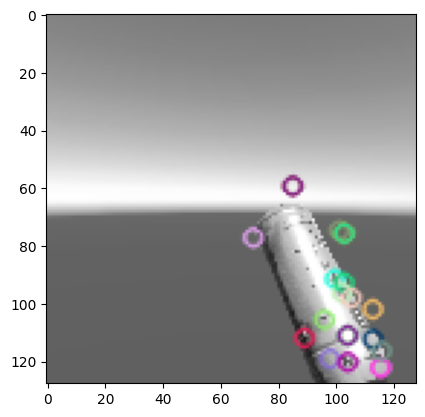

In [57]:
display_sift_features(image_padded)

In [58]:
'''
Each ***keypoint*** has a location, scale, orientation. 
Each ***descriptor*** stores the local image region about each keypoint 
  that is distinct and invariant to variations such as changes in viewpoint and illumination
'''

keypoints, descriptors = get_sift_feature_vector(image_padded)
print('keypoints: ', keypoints[:3])
print('descriptors: ', descriptors[:3])
print('number of features: ', len(flatten_sift_descriptors(descriptors)))

keypoints:  (< cv2.KeyPoint 0x7f9bc50486f0>, < cv2.KeyPoint 0x7f9bc51cc5a0>, < cv2.KeyPoint 0x7f9bc4f3d4e0>)
descriptors:  [[  1.   0.   0.   0.   0.   0.   0.   0. 115.  21.   0.   0.   0.   0.
    0.   0. 147.  57.   0.   1.  46.   1.   0.   0.   6.   2.   0.   2.
  147.   3.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1. 122.  14.
    0.   0.   0.   0.   1.  23. 147.  52.   0.   2.  47.   0.   0.  24.
   17.   4.   0.   2. 147.   5.   0.   0.   1.   0.   0.   0.   0.   0.
   10.  25.  35.   4.  11.   4.   0.   0.  43. 147. 147.  40.  13.   4.
   33.   2.   7. 138.  14.   4.   0.   2. 147.  18.   0.   1.   1.   0.
    7.   3.   0.   0.   6.  15.   8.  13.  81.  52.   0.   0.  13.  62.
   91.  97.  45.  15.  11.   2.   1.   9.  17.   8.   0.   0.  93.  16.
    0.   0.]
 [  3.   3.   6.  51.  19.   9.  50.  25.  69.  66.   8.   5.   2.  28.
   64.  11. 133.  32.   0.   0.   0.   7.  37.  38.   6.   0.   0.   0.
    0.  40. 123.  14.  59.  46.  25.  10.  27.  22.  53.  77.  58.  19.


# Crop Objects from Images

In [61]:
# output_path = '/content/'

output_path = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_SYNTHETIC_IMAGES_RESIZED/'

# get all objects from the images and append the bottle label
for image in synthetic_files:    
    I = np.asarray(PIL.Image.open(SYNTHETIC_IMAGE_PATH + '/' + image).convert('RGB'))
    image_padded = resize_with_pad(I, (128, 128))
    im = Image.fromarray(image_padded)
    im.save(output_path + image.split('.')[0] + '_bottle.jpg')

# Assign Labels to Images *****

In [69]:
# filepath = '/content/'
filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_SYNTHETIC_IMAGES_RESIZED/'

# list out the image files
cropped_filenames = os.listdir(filepath)

filenames = []

for file in os.listdir(filepath):
    if file.endswith('.jpg'):
        filenames.append(file)

print(len(filenames))
filenames[:5]

8000


['rgb_6989_bottle.jpg',
 'rgb_6994_bottle.jpg',
 'rgb_6976_bottle.jpg',
 'rgb_6984_bottle.jpg',
 'rgb_7015_bottle.jpg']

In [70]:
def get_label_from_cropped_filename(filename):

    label = filename.split('.')[0].split('_')[-1]

    return label

In [71]:
# add filenames to a dataframe
image_df = pd.DataFrame({'filename':filenames})

# get full filepath
image_df['filepath'] = filepath + image_df['filename']

# get label
image_df['label'] = image_df.apply(lambda x: get_label_from_cropped_filename(x['filename']), axis=1)

image_df.head()

,filename,filepath,label
0,rgb_6989_bottle.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,bottle
1,rgb_6994_bottle.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,bottle
2,rgb_6976_bottle.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,bottle
3,rgb_6984_bottle.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,bottle
4,rgb_7015_bottle.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,bottle


# Class Distribution

In [3]:
train_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/train_images_with_labels.csv'
train_df = pd.read_csv(train_filepath).drop(columns=['Unnamed: 0'])
val_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/val_images_with_labels.csv'
val_df = pd.read_csv(val_filepath).drop(columns=['Unnamed: 0'])
test_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/test_images_with_labels.csv'
test_df = pd.read_csv(test_filepath).drop(columns=['Unnamed: 0'])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
trainval_df = train_df.append(val_df)
print(trainval_df.shape)
all_df = trainval_df.append(test_df)
print(all_df.shape)
all_df.head()

(16616, 3)
(2374, 3)
(4748, 3)
(18990, 3)
(23738, 3)


<ipython-input-3-c4e2e92067d5>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trainval_df = train_df.append(val_df)
<ipython-input-3-c4e2e92067d5>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = trainval_df.append(test_df)


,filename,filepath,label
0,2008_003463_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
1,2009_003705_aeroplane.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,aeroplane
2,2011_002063_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
3,2008_002813_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
4,2010_006952_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person


[Text(0, 0, 'person'),
 Text(1, 0, 'chair'),
 Text(2, 0, 'dog'),
 Text(3, 0, 'car'),
 Text(4, 0, 'cat'),
 Text(5, 0, 'bottle'),
 Text(6, 0, 'bird'),
 Text(7, 0, 'sofa'),
 Text(8, 0, 'aeroplane'),
 Text(9, 0, 'diningtable'),
 Text(10, 0, 'tvmonitor'),
 Text(11, 0, 'pottedplant'),
 Text(12, 0, 'bicycle'),
 Text(13, 0, 'train'),
 Text(14, 0, 'motorbike'),
 Text(15, 0, 'boat'),
 Text(16, 0, 'horse'),
 Text(17, 0, 'bus'),
 Text(18, 0, 'sheep'),
 Text(19, 0, 'cow')]

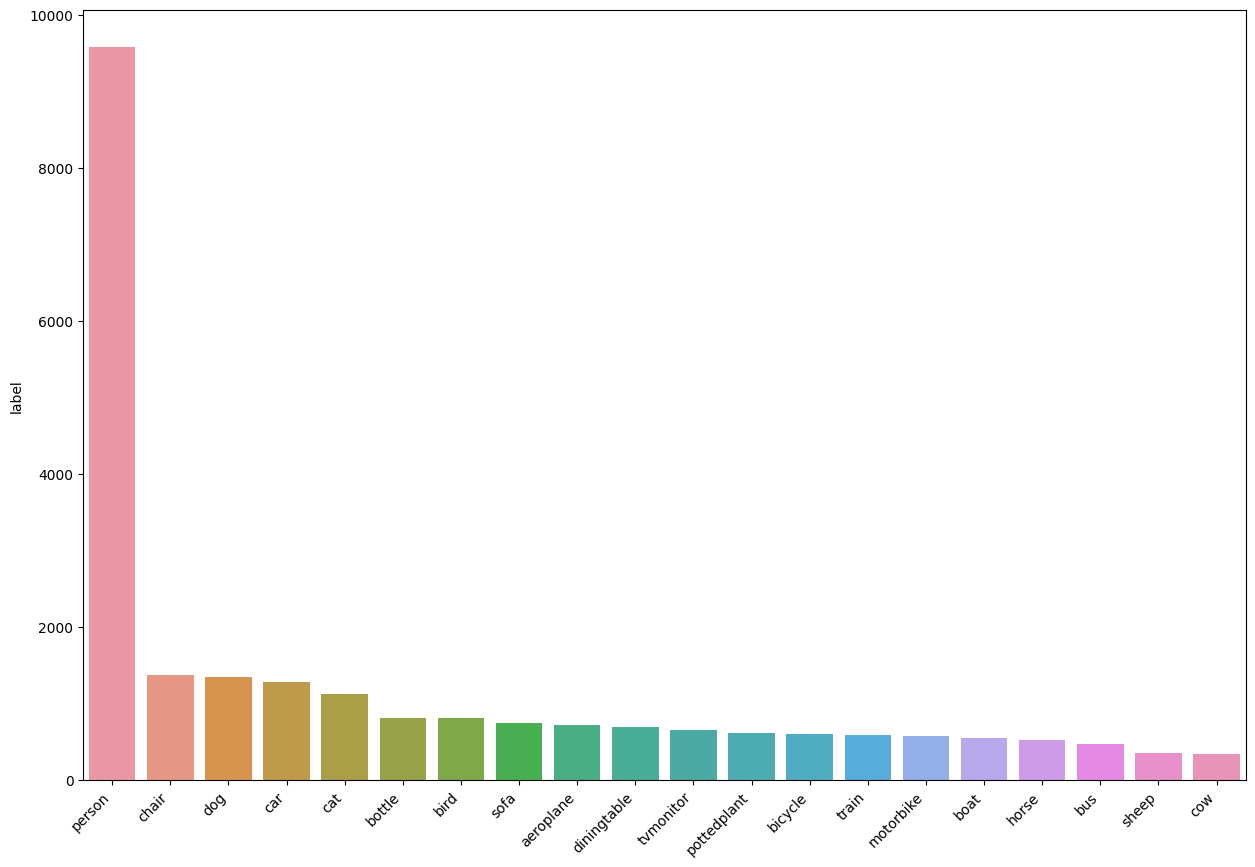

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x=all_df['label'].value_counts().index, y=all_df['label'].value_counts(), ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add Bottle Images to Train Set

In [79]:
# read in the train set
train_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/train_images_with_labels.csv'
train_df = pd.read_csv(train_filepath).drop(columns=['Unnamed: 0'])
train_df.head()

,filename,filepath,label
0,2008_003463_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
1,2009_003705_aeroplane.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,aeroplane
2,2011_002063_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
3,2008_002813_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
4,2010_006952_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person


In [81]:
# check number of labeled classes in *TRAIN* PASCAL VOC dataset
print(train_df['label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

person         40.4%
chair           5.8%
dog             5.5%
car             5.4%
cat             4.7%
bird            3.5%
bottle          3.3%
sofa            3.2%
aeroplane       2.9%
diningtable     2.9%
tvmonitor       2.8%
pottedplant     2.6%
bicycle         2.5%
train           2.5%
motorbike       2.4%
boat            2.3%
horse           2.2%
bus             2.0%
sheep           1.5%
cow             1.5%
Name: label, dtype: object


In [80]:
# append synthetic images to train set
print(train_df.shape)
train_synthetic_df = train_df.append(image_df, ignore_index=True)
print(train_synthetic_df.shape)

# export new train set
train_synthetic_df.to_csv('/content/train_synthetic_images_with_labels.csv')

(16616, 3)
(24616, 3)


<ipython-input-80-a34b82e124dc>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_synthetic_df = train_df.append(image_df, ignore_index=True)


In [82]:
# check number of labeled classes in *TRAIN + SYNTHETIC* PASCAL VOC dataset
print(train_synthetic_df['label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

bottle         34.7%
person         27.3%
chair           3.9%
dog             3.7%
car             3.6%
cat             3.2%
bird            2.4%
sofa            2.2%
aeroplane       2.0%
diningtable     1.9%
tvmonitor       1.9%
pottedplant     1.7%
bicycle         1.7%
train           1.7%
motorbike       1.7%
boat            1.5%
horse           1.5%
bus             1.3%
sheep           1.0%
cow             1.0%
Name: label, dtype: object


## Train

In [113]:
# append the image data now to the train subset
train_synthetic_df['image_data_unpadded'] = train_synthetic_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

train_synthetic_df['image_data_padded'] = train_synthetic_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
train_synthetic_df.head()

,filename,filepath,label,image_data_unpadded,image_data_padded
0,2008_003463_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[133, 125, 114], [133, 125, 114], [135, 127,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,2009_003705_aeroplane.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,aeroplane,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,2011_002063_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[3, 3, 1], [3, 3, 1], [3, 3, 1], [3, 3, 1], ...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,2008_002813_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[107, 105, 118], [96, 98, 110], [113, 121, 1...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,2010_006952_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[52, 71, 88], [65, 84, 101], [69, 87, 107], ...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [114]:
# HOG
train_synthetic_df['hog_vector'] = train_synthetic_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded']), axis=1)

# create hog vector df
hog_train_unsplit_df = train_synthetic_df[['label','hog_vector']]
hog_train_unsplit_df.head()

num_hog_features = len(hog_train_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = train_synthetic_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_train_temp_df = pd.DataFrame(hog_train_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_train_df = hog_train_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_train_df.to_csv('/content/final_train_hog_vectors.csv')

hog_train_df.head()

,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,hog_10,...,hog_1756,hog_1757,hog_1758,hog_1759,hog_1760,hog_1761,hog_1762,hog_1763,hog_1764,label
0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,person
1,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,aeroplane
2,0.356393,0.000455,0.00259,0.00091,0.004681,0.001365,0.000576,0.0,0.356393,0.123272,...,0.383934,0.076459,0.032414,0.067362,0.104033,0.114174,0.01915,0.009199,0.251506,person
3,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.499951,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,person
4,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.492967,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,person


In [115]:
# HSV
train_synthetic_df['hsv_vector'] = train_synthetic_df.apply(lambda x: get_hsv_feature_vector(x['image_data_unpadded']), axis=1)

# create hsv vector df
hsv_train_unsplit_df = train_synthetic_df[['label','hsv_vector']]

num_hsv_features = len(hsv_train_unsplit_df.iloc[0][1]) + 1
hsv_columns = [f'hsv_{num}' for num in range(1, num_hsv_features)]
hsv_labels = train_synthetic_df['label'].tolist()
hsv_labels_series = pd.Series(hsv_labels)

# split the hog vector into their own columns
hsv_train_temp_df = pd.DataFrame(hsv_train_unsplit_df['hsv_vector'].to_list(), columns=hsv_columns)

# merge
hsv_train_df = hsv_train_temp_df.merge(hsv_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hsv_train_df.to_csv('/content/final_train_hsv_vectors.csv')

hsv_train_df.head()

,hsv_1,hsv_2,hsv_3,hsv_4,hsv_5,hsv_6,hsv_7,hsv_8,hsv_9,hsv_10,...,hsv_88,hsv_89,hsv_90,hsv_91,hsv_92,hsv_93,hsv_94,hsv_95,hsv_96,label
0,3574.0,3591.0,3299.0,3033.0,3231.0,3609.0,3497.0,3852.0,4069.0,4155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
1,216.0,786.0,2048.0,2041.0,1753.0,1471.0,1238.0,1016.0,888.0,993.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aeroplane
2,8245.0,8869.0,5098.0,4244.0,2537.0,1540.0,1310.0,1166.0,1275.0,1120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
3,28.0,82.0,66.0,51.0,144.0,339.0,817.0,2453.0,5109.0,8331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
4,23.0,78.0,299.0,1293.0,1987.0,2005.0,1804.0,1708.0,1437.0,1170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person


In [116]:
# SIFT
train_synthetic_df['sift_vector'] = train_synthetic_df.apply(lambda x: get_sift_feature_vector(x['image_data_padded'])[1], axis=1)
train_synthetic_df['sift_vector'] = train_synthetic_df['sift_vector'].apply(lambda x: flatten_sift_descriptors(np.array(x)))

# create sift vector df
sift_train_unsplit_df = train_synthetic_df[['label','sift_vector']]

num_sift_features = 3072 + 1
sift_columns = [f'sift_{num}' for num in range(1, num_sift_features)]
sift_labels = train_synthetic_df['label'].tolist()
sift_labels_series = pd.Series(hsv_labels)

# split the sift vector into their own columns
sift_train_temp_df = pd.DataFrame(sift_train_unsplit_df['sift_vector'].to_list(), columns=sift_columns)

# replace NaN with 0
sift_train_temp_df = sift_train_temp_df.fillna(0)

# merge
sift_train_df = sift_train_temp_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
sift_train_df.to_csv('/content/final_train_sift_vectors.csv')

sift_train_df.head()

,sift_1,sift_2,sift_3,sift_4,sift_5,sift_6,sift_7,sift_8,sift_9,sift_10,...,sift_3064,sift_3065,sift_3066,sift_3067,sift_3068,sift_3069,sift_3070,sift_3071,sift_3072,label
0,8.0,2.0,2.0,2.0,3.0,15.0,106.0,96.0,12.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
1,4.0,0.0,1.0,11.0,50.0,71.0,41.0,14.0,38.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aeroplane
2,1.0,0.0,2.0,1.0,2.0,1.0,1.0,7.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
3,54.0,23.0,22.0,19.0,11.0,13.0,1.0,5.0,51.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
4,1.0,26.0,125.0,20.0,3.0,3.0,1.0,0.0,165.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person


## Val

In [118]:
# read in the val set
val_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/val_images_with_labels.csv'
val_df = pd.read_csv(val_filepath).drop(columns=['Unnamed: 0'])
val_df.head()

,filename,filepath,label
0,2007_004291_bottle.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,bottle
1,2012_003924_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
2,2007_001901_diningtable.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,diningtable
3,2011_004711_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
4,2010_004987_chair.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,chair


In [119]:
# append the image data now to the val subset
val_df['image_data_unpadded'] = val_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

val_df['image_data_padded'] = val_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
val_df.head()

,filename,filepath,label,image_data_unpadded,image_data_padded
0,2007_004291_bottle.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,bottle,"[[[80, 36, 0], [77, 33, 0], [73, 27, 1], [71, ...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,2012_003924_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[178, 137, 119], [179, 138, 120], [180, 139,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,2007_001901_diningtable.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,diningtable,"[[[27, 16, 20], [23, 13, 12], [49, 40, 33], [5...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,2011_004711_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[46, 52, 42], [46, 52, 42], [46, 52, 42], [4...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,2010_004987_chair.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,chair,"[[[85, 81, 80], [91, 87, 86], [90, 86, 85], [8...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [120]:
# HOG
val_df['hog_vector'] = val_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded']), axis=1)

# create hog vector df
hog_val_unsplit_df = val_df[['label','hog_vector']]
hog_val_unsplit_df.head()

num_hog_features = len(hog_val_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]

# split the hog vector into their own columns
hog_val_temp_df = pd.DataFrame(hog_val_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_val_df = pd.merge(hog_val_unsplit_df, hog_val_temp_df, left_index=True, right_index=True)

# drop hog vector
hog_val_df = hog_val_df.drop(columns=['hog_vector'])

# export to csv
hog_val_df.to_csv('/content/final_val_hog_vectors.csv')

hog_val_df.head()

,label,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,...,hog_1755,hog_1756,hog_1757,hog_1758,hog_1759,hog_1760,hog_1761,hog_1762,hog_1763,hog_1764
0,bottle,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.498363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,person,0.306701,0.049976,0.040417,0.000000,0.007414,0.038210,0.048828,0.247919,0.345033,...,0.015321,0.368016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136625
2,diningtable,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.497857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,person,0.131135,0.041883,0.009254,0.006839,0.295886,0.120178,0.055970,0.042439,0.045358,...,0.042423,0.002235,0.044761,0.119654,0.098037,0.386291,0.023383,0.002235,0.005472,0.007969
4,chair,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.447831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [121]:
# HSV
val_df['hsv_vector'] = val_df.apply(lambda x: get_hsv_feature_vector(x['image_data_unpadded']), axis=1)

# create hsv vector df
hsv_val_unsplit_df = val_df[['label','hsv_vector']]

num_hsv_features = len(hsv_val_unsplit_df.iloc[0][1]) + 1
hsv_columns = [f'hsv_{num}' for num in range(1, num_hsv_features)]

# split the hsv vector into their own columns
hsv_val_temp_df = pd.DataFrame(hsv_val_unsplit_df['hsv_vector'].to_list(), columns=hsv_columns)

# merge
hsv_val_df = pd.merge(hsv_val_unsplit_df, hsv_val_temp_df, left_index=True, right_index=True)

# drop hsv vector
hsv_val_df = hsv_val_df.drop(columns=['hsv_vector'])

# export to csv
hsv_val_df.to_csv('/content/final_val_hsv_vectors.csv')

hsv_val_df.head()

,label,hsv_1,hsv_2,hsv_3,hsv_4,hsv_5,hsv_6,hsv_7,hsv_8,hsv_9,...,hsv_87,hsv_88,hsv_89,hsv_90,hsv_91,hsv_92,hsv_93,hsv_94,hsv_95,hsv_96
0,bottle,0.0,1.0,1263.0,2028.0,1677.0,1436.0,1311.0,1031.0,785.0,...,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,person,115.0,210.0,376.0,807.0,1020.0,870.0,801.0,789.0,731.0,...,669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,diningtable,86.0,1621.0,3127.0,1933.0,1531.0,2068.0,1378.0,948.0,752.0,...,274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,person,1.0,32.0,519.0,1864.0,3250.0,4701.0,5821.0,6195.0,7295.0,...,551.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chair,804.0,4222.0,1986.0,1510.0,1109.0,1003.0,1283.0,1903.0,1749.0,...,1853.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
# SIFT
val_df['sift_vector'] = val_df.apply(lambda x: get_sift_feature_vector(x['image_data_padded'])[1], axis=1)
val_df['sift_vector'] = val_df['sift_vector'].apply(lambda x: flatten_sift_descriptors(np.array(x)))

# create sift vector df
sift_val_unsplit_df = val_df[['label','sift_vector']]

num_sift_features = 2944 + 1
sift_columns = [f'sift_{num}' for num in range(1, num_sift_features)]
sift_labels = val_df['label'].tolist()
sift_labels_series = pd.Series(sift_labels)

# split the sift vector into their own columns
sift_val_temp_df = pd.DataFrame(sift_val_unsplit_df['sift_vector'].to_list(), columns=sift_columns)

# replace NaN with 0
sift_val_temp_df = sift_val_temp_df.fillna(0)

# merge
sift_val_df = sift_val_temp_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
sift_val_df.to_csv('/content/final_val_sift_vectors.csv')

sift_val_df.head()

,sift_1,sift_2,sift_3,sift_4,sift_5,sift_6,sift_7,sift_8,sift_9,sift_10,...,sift_2936,sift_2937,sift_2938,sift_2939,sift_2940,sift_2941,sift_2942,sift_2943,sift_2944,label
0,17.0,2.0,2.0,5.0,2.0,1.0,0.0,3.0,173.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bottle
1,2.0,12.0,9.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
2,7.0,1.0,0.0,0.0,0.0,0.0,14.0,44.0,55.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,diningtable
3,92.0,20.0,17.0,6.0,1.0,4.0,5.0,74.0,114.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
4,1.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chair


## Test

In [124]:
# read in the test set
test_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/test_images_with_labels.csv'
test_df = pd.read_csv(test_filepath).drop(columns=['Unnamed: 0'])
test_df.head()

,filename,filepath,label
0,2010_004506_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
1,2012_001337_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person
2,2009_004942_horse.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,horse
3,2010_003174_sofa.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,sofa
4,2008_002185_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person


In [125]:
# append the image data now to the test subset
test_df['image_data_unpadded'] = test_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

test_df['image_data_padded'] = test_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
test_df.head()

,filename,filepath,label,image_data_unpadded,image_data_padded
0,2010_004506_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[101, 102, 106], [132, 135, 140], [105, 110,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,2012_001337_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[204, 203, 198], [204, 203, 198], [204, 203,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,2009_004942_horse.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,horse,"[[[149, 169, 202], [149, 169, 202], [149, 169,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,2010_003174_sofa.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,sofa,"[[[13, 13, 15], [13, 13, 15], [13, 13, 15], [1...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,2008_002185_person.jpg,/content/drive/MyDrive/DATASCI281_FinalProject...,person,"[[[188, 191, 184], [191, 193, 188], [182, 183,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [126]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded']), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

num_hog_features = len(hog_test_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,hog_10,...,hog_1756,hog_1757,hog_1758,hog_1759,hog_1760,hog_1761,hog_1762,hog_1763,hog_1764,label
0,0.119916,0.097905,0.169147,0.264452,0.357141,0.180447,0.167756,0.089748,0.031534,0.003076,...,0.027259,0.013611,0.005200,0.006875,0.555946,0.397271,0.106216,0.061037,0.037654,person
1,0.006222,0.003865,0.017110,0.004638,0.308240,0.010756,0.003959,0.000000,0.000000,0.006568,...,0.016096,0.014682,0.028794,0.058956,0.655583,0.030697,0.003671,0.011012,0.000000,person
2,0.024260,0.017762,0.029955,0.083513,0.471261,0.088847,0.083859,0.038975,0.015275,0.054287,...,0.045161,0.058117,0.048533,0.052237,0.461506,0.204526,0.131333,0.071495,0.034977,horse
3,0.671285,0.005340,0.003630,0.000000,0.003850,0.011204,0.004333,0.014182,0.281512,0.095322,...,0.320281,0.000462,0.003509,0.002832,0.001654,0.001979,0.002632,0.000925,0.320281,sofa
4,0.353397,0.000000,0.025021,0.037200,0.039705,0.018097,0.091943,0.053214,0.353397,0.062304,...,0.350728,0.072423,0.123687,0.016306,0.014504,0.001523,0.001396,0.003333,0.350728,person


In [127]:
# HSV
test_df['hsv_vector'] = test_df.apply(lambda x: get_hsv_feature_vector(x['image_data_unpadded']), axis=1)

# create hsv vector df
hsv_test_unsplit_df = test_df[['label','hsv_vector']]

num_hsv_features = len(hsv_test_unsplit_df.iloc[0][1]) + 1
hsv_columns = [f'hsv_{num}' for num in range(1, num_hsv_features)]
hsv_labels = test_df['label'].tolist()
hsv_labels_series = pd.Series(hsv_labels)

# split the hog vector into their own columns
hsv_test_temp_df = pd.DataFrame(hsv_test_unsplit_df['hsv_vector'].to_list(), columns=hsv_columns)

# merge
hsv_test_df = hsv_test_temp_df.merge(hsv_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hsv_test_df.to_csv('/content/final_test_hsv_vectors.csv')

hsv_test_df.head()

,hsv_1,hsv_2,hsv_3,hsv_4,hsv_5,hsv_6,hsv_7,hsv_8,hsv_9,hsv_10,...,hsv_88,hsv_89,hsv_90,hsv_91,hsv_92,hsv_93,hsv_94,hsv_95,hsv_96,label
0,2.0,3.0,175.0,1296.0,1395.0,1557.0,1755.0,2246.0,2568.0,2873.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
1,103.0,236.0,718.0,2651.0,11345.0,7843.0,2330.0,1838.0,1821.0,1890.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
2,1.0,10.0,11.0,52.0,69.0,117.0,209.0,294.0,480.0,867.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,horse
3,20646.0,8330.0,7325.0,11539.0,18149.0,7356.0,7809.0,8128.0,8077.0,7480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sofa
4,2587.0,3417.0,5605.0,6516.0,7227.0,5035.0,3594.0,2720.0,1627.0,1247.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person


In [128]:
# SIFT
test_df['sift_vector'] = test_df.apply(lambda x: get_sift_feature_vector(x['image_data_padded'])[1], axis=1)
test_df['sift_vector'] = test_df['sift_vector'].apply(lambda x: flatten_sift_descriptors(np.array(x)))

# create sift vector df
sift_test_unsplit_df = test_df[['label','sift_vector']]

num_sift_features = 2944 + 1
sift_columns = [f'sift_{num}' for num in range(1, num_sift_features)]
sift_labels = test_df['label'].tolist()
sift_labels_series = pd.Series(sift_labels)

# split the sift vector into their own columns
sift_test_temp_df = pd.DataFrame(sift_test_unsplit_df['sift_vector'].to_list(), columns=sift_columns)

# replace NaN with 0
sift_test_temp_df = sift_test_temp_df.fillna(0)

# merge
sift_test_df = sift_test_temp_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
sift_test_df.to_csv('/content/final_test_sift_vectors.csv')

sift_test_df.head()

,sift_1,sift_2,sift_3,sift_4,sift_5,sift_6,sift_7,sift_8,sift_9,sift_10,...,sift_2936,sift_2937,sift_2938,sift_2939,sift_2940,sift_2941,sift_2942,sift_2943,sift_2944,label
0,1.0,2.0,6.0,9.0,16.0,28.0,3.0,1.0,117.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
1,0.0,0.0,14.0,9.0,3.0,0.0,0.0,0.0,17.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person
2,25.0,34.0,0.0,9.0,35.0,16.0,2.0,9.0,69.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,horse
3,58.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,145.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sofa
4,1.0,2.0,7.0,90.0,72.0,42.0,44.0,5.0,57.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,person


# Models

## SVM - HOG

In [148]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [149]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [150]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [151]:
pipe.score(x_test, y_test)

0.4886267902274642

In [152]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

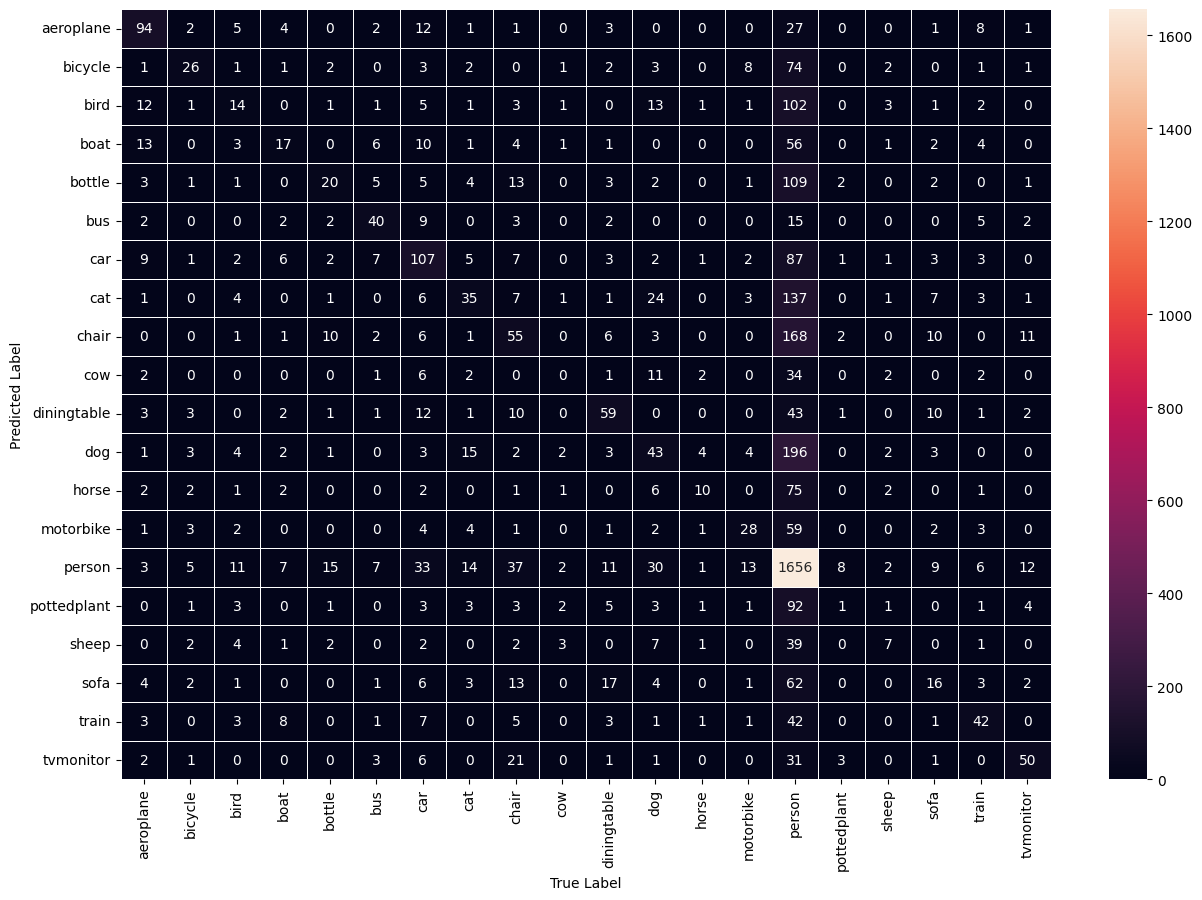

In [155]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.60      0.58      0.59       161
     bicycle       0.49      0.20      0.29       128
        bird       0.23      0.09      0.13       162
        boat       0.32      0.14      0.20       119
      bottle       0.34      0.12      0.17       172
         bus       0.52      0.49      0.50        82
         car       0.43      0.43      0.43       249
         cat       0.38      0.15      0.22       232
       chair       0.29      0.20      0.24       276
         cow       0.00      0.00      0.00        63
 diningtable       0.48      0.40      0.44       149
         dog       0.28      0.15      0.19       288
       horse       0.43      0.10      0.16       105
   motorbike       0.44      0.25      0.32       111
      person       0.53      0.88      0.66      1882
 pottedplant       0.06      0.01      0.01       125
       sheep       0.29      0.10      0.15        71
        sofa       0.24    

## SVM - HSV

In [136]:
x_train = pd.DataFrame(hsv_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hsv_train_df['label']).to_numpy().ravel()

In [137]:
x_test = pd.DataFrame(hsv_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hsv_test_df['label']).to_numpy().ravel()

In [138]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [139]:
pipe.score(x_test, y_test)

0.3473041280539174

In [140]:
y_pred = pipe.predict(x_test)

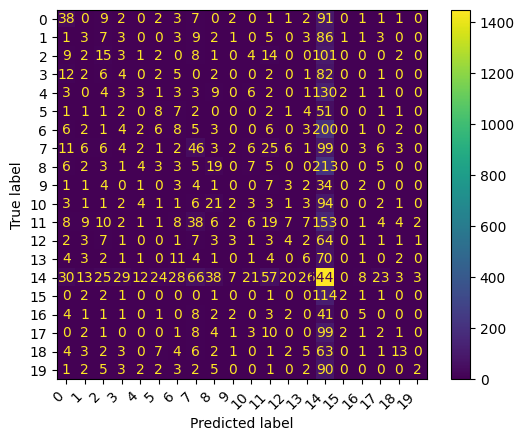

In [141]:
color = 'white'
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.26      0.24      0.25       161
     bicycle       0.05      0.02      0.03       128
        bird       0.13      0.09      0.11       162
        boat       0.06      0.03      0.04       119
      bottle       0.09      0.02      0.03       172
         bus       0.13      0.10      0.11        82
         car       0.09      0.03      0.05       249
         cat       0.20      0.20      0.20       232
       chair       0.15      0.07      0.10       276
         cow       0.00      0.00      0.00        63
 diningtable       0.05      0.02      0.03       149
         dog       0.11      0.07      0.08       288
       horse       0.09      0.04      0.05       105
   motorbike       0.09      0.05      0.07       111
      person       0.44      0.77      0.56      1882
 pottedplant       0.29      0.02      0.03       125
       sheep       0.18      0.07      0.10        71
        sofa       0.04    